# Testing notebook
In this notebook, we load our 9 trained models that has been saved on Kaggle collection, to test on `testset` and compare their performance

# 1. Download resource

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


## Download library

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [3]:
import numpy as np
np.__version__

'1.26.4'

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [5]:
# import pandas as pd
import datasets
import numpy as np
import re,string
import torch
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

## Load dataset

In [6]:
data_path = f"{path}/IMDB Dataset.csv"

df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Visualize the balance of data

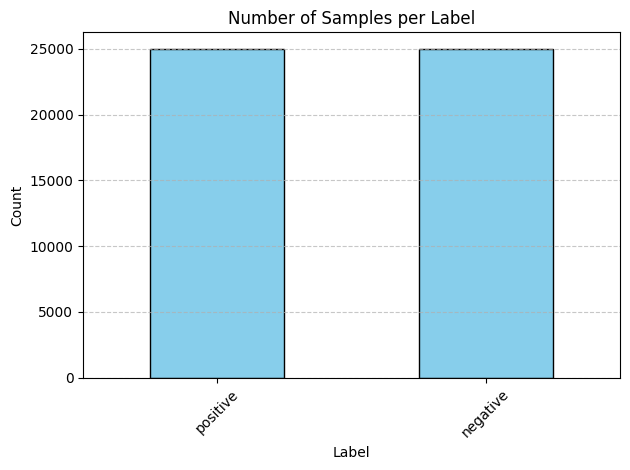

In [7]:
import matplotlib.pyplot as plt

# Count the number of samples in each label
label_counts = df['sentiment'].value_counts()

# Plot a column diagram (bar chart)
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Samples per Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Load into `Datasets` object

In [8]:
from datasets import Dataset, DatasetDict

df['labels'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
dataset = Dataset.from_pandas(df)

dataset

Dataset({
    features: ['review', 'sentiment', 'labels'],
    num_rows: 50000
})

## Create `DatasetDict` object

In [9]:
# First split into train+val and test
train_val_split = dataset.train_test_split(test_size=0.2, seed=42)

# Then split train+val into train and val
train_val = train_val_split['train'].train_test_split(test_size=0.125, seed=42)  # 0.125 x 0.8 = 0.1

# Combine everything into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_val['train'],
    'validation': train_val['test'],
    'test': train_val_split['test']
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 10000
    })
})


# 2. Build abstract function

## 2.1 Preprocessing function

In [10]:
from torch.utils.data import DataLoader, Dataset

# Function to tokenize and include labels
def tokenize_function(examples, tokenizer, max_length):
    tokenized_output = tokenizer(examples["review"], truncation=True, padding="max_length", max_length=max_length)
    return tokenized_output

def preprocessing(dataset_dict, tokenizer, batch_size, max_model_length=None):
    fn_kwargs = {
        "tokenizer": tokenizer,
        "max_length": max_model_length
    }

    # Apply the tokenize_function to the datasets
    train_dataset = dataset_dict["train"].map(tokenize_function, fn_kwargs=fn_kwargs, batched=True)
    val_dataset = dataset_dict["validation"].map(tokenize_function, fn_kwargs=fn_kwargs, batched=True)
    test_dataset = dataset_dict["test"].map(tokenize_function, fn_kwargs=fn_kwargs, batched=True)

    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"]) # changed "label" to "labels"
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"]) # changed "label" to "labels"

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## 2.2 Training function

In [11]:
from tqdm import tqdm
from torch.optim import AdamW
from peft import get_peft_model_state_dict, set_peft_model_state_dict
from sklearn.metrics import accuracy_score
import time
import datetime

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def accuracy_score_fn(outputs, labels):
    predictions = np.argmax(outputs, axis=1)
    return accuracy_score(labels, predictions)

def save_model(model, path):
    model_state_dict = get_peft_model_state_dict(model)
    torch.save(model_state_dict, path)

def evaluate_fn(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Evaluate model", leave=False)

        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device

            # Prepare inputs for the model
            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels,
            }

            outputs = model(**model_inputs)
            loss = outputs.loss
            total_loss += loss.item()

            # Accuracy score
            all_preds.extend(outputs.logits.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

            ### TODO: DELETE IT
            # break

    avg_val_loss = total_loss / len(val_loader)
    value = accuracy_score_fn(np.array(all_preds), np.array(all_labels))
    return avg_val_loss, value

def train_and_save(model, train_loader, val_loader, output_dir, device, lr, epochs, save_fn = save_model):
    # only update the parameters that require gradients in the case of BitFit or Lora
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    best_loss = float('inf')

    for epoch in range(1, epochs + 1):
        start = time.time()
        model.train()
        total_loss = 0.0
        patience = 0        # Early stopping

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)

        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)  # Assuming labels are numerical

            # Prepare inputs for the model
            model_inputs = {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels,
            }

            outputs = model(**model_inputs)

            loss = outputs.loss # Loss function is provided by the Sentence Classification head
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

            ### TODO: DELETE IT
            # break

        avg_loss = total_loss / len(train_loader)

        val_loss, accuracy_score = evaluate_fn(model, val_loader, device)
        train_duration = time.time() - start
        print(f"Epoch {epoch} - Average loss: {avg_loss:.4f} - Trainning duration: {str(datetime.timedelta(seconds=int(train_duration)))}")
        print(f"Average Validation: {val_loss:.4f} - Validation accuracy: {accuracy_score:.4f}")

        if val_loss < best_loss:
            patience = 0
            best_loss = val_loss
            save_fn(model, output_dir)
            print(f"Saved model in {output_dir}")
        else:
            patience += 1
            if patience == 2:
                print("Early stopping triggered. No improvement in validation loss.")
                break

2025-06-01 04:26:38.604741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748751998.802942      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748751998.858723      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2.3 Path of Trained Model

### Download trained model from collection

In [12]:
# Download latest version
model_path = kagglehub.model_download("trungtranhcmut/assignment-text-classification-model/pyTorch/default")

print("Path to model files:", model_path)

for dirname, _, filenames in os.walk(model_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Path to model files: /kaggle/input/assignment-text-classification-model/pytorch/default/4
/kaggle/input/assignment-text-classification-model/pytorch/default/4/bert_prompt_model_v06_05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/bert_lora_model_v01_05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/roberta-base_prompt_model_v06_05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/distilbert-base-uncased_bitfit_model_v15-05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/bert_bitfit_model_v15-05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/distilbert-base-uncased_lora_model_v06_05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/distilbert-base-uncased_prompt_model_v02_05.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/roberta-base_lora_model_v1.pt
/kaggle/input/assignment-text-classification-model/pytorch/default/4/ro

In [13]:
# MODEL_PATH = "/kaggle/input/assignment-text-classification-model/pytorch/default/3/"
MODEL_PATH = model_path

path_bert_lora_model = f"{MODEL_PATH}/bert_lora_model_v01_05.pt"
path_bert_bitfit_model = f"{MODEL_PATH}/bert_bitfit_model_v15-05.pt"
path_bert_prompt_model = f"{MODEL_PATH}/bert_prompt_model_v06_05.pt"

path_roberta_lora_model = f"{MODEL_PATH}/roberta-base_lora_model_v1.pt"
path_roberta_bitfit_model = f"{MODEL_PATH}/roberta-base_bitfit_model_v15-05.pt"
path_roberta_prompt_model = f"{MODEL_PATH}/roberta-base_prompt_model_v06_05.pt"

path_dibert_lora_model = f"{MODEL_PATH}/distilbert-base-uncased_lora_model_v06_05.pt"
path_dibert_bitfit_model = f"{MODEL_PATH}/distilbert-base-uncased_bitfit_model_v15-05.pt"
path_dibert_prompt_model = f"{MODEL_PATH}/distilbert-base-uncased_prompt_model_v02_05.pt"

# 3. `BERT` Model

## 3.1 Download model

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
checkpoint = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preprocessing dataset

In [15]:
BATCH_SIZE = 32

train_loader, val_loader, test_loader = preprocessing(dataset_dict, bert_tokenizer, BATCH_SIZE)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## 3.2 LoRA tuning

### Load model and config hyperparams

In [16]:
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict
from sklearn.metrics import accuracy_score # Import accuracy_score

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3

lora_config = LoraConfig(
    r=8,  # Rank of low-rank matrices => About 5~10M trainable params
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="SEQ_CLS",  # For sequence classification task
)

lora_bert_model = get_peft_model(bert_model, lora_config)
lora_bert_model.to(device)

print(f"The model has {count_parameters(lora_bert_model):,} trainable parameters")

The model has 296,450 trainable parameters


### Load trained params

In [17]:
# Load the state dictionary into the model
state_dict = torch.load(path_bert_lora_model)
set_peft_model_state_dict(lora_bert_model, state_dict)

# _, acc = evaluate_fn(lora_bert_model, test_loader, device)
# print(f"Test accuracy: ", acc)

print(f"The model has {count_parameters(lora_bert_model):,} trainable parameters")

The model has 296,450 trainable parameters


### Testing result on Testset

In [18]:
lora_bert_loss, lora_bert_acc = evaluate_fn(lora_bert_model, test_loader, device)

print("Model accuracy: ", lora_bert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.9338


## 3.3 BitFit Tuning

In [19]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3

# Load the base model (e.g., for text classification)
bert_bitfit_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
bert_bitfit_model = bert_bitfit_model.to(device)

# Freeze all parameters
for param in bert_bitfit_model.parameters():
    param.requires_grad = False

# Enable training for bias terms only
for name, param in bert_bitfit_model.named_parameters():
    if 'bias' in name:
        param.requires_grad = True

print(f"The model has {count_parameters(bert_bitfit_model):,} trainable parameters")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model has 102,914 trainable parameters


### Load trained model

In [20]:
bias_weights = torch.load(path_bert_bitfit_model)
bert_bitfit_model.load_state_dict(bias_weights, strict=True)  # strict=False because not loading all weights

print("Load complete !")

Load complete !


### Testing on testset

In [21]:
bitfit_bert_loss, bitfit_bert_acc = evaluate_fn(bert_bitfit_model, test_loader, device)

print("Model accuracy: ", bitfit_bert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.9258


## 3.4 `Prompt Tuning`

### Load config

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PromptTuningConfig, get_peft_model, TaskType

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
NUM_VIRTUAL_TOKEN = 20
LEARNING_RATE = 1e-3
EPOCHS = 3

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Define Prompt Tuning config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,       # Sequence classification
    num_virtual_tokens=NUM_VIRTUAL_TOKEN,            # Number of prompt tokens (adjustable)
    tokenizer_name_or_path="bert-base-uncased"
)

bert_prompt_model = get_peft_model(base_model, peft_config)
bert_prompt_model.to(device)

count_parameters(bert_prompt_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


16898

### Update dataloader
Because in Prompt Tuning, the max size of model's token need to be adjusted due to the change in the

In [23]:
max_model_length = bert_tokenizer.model_max_length
adjusted_length = max_model_length - NUM_VIRTUAL_TOKEN

prompt_train_loader, prompt_val_loader, prompt_test_loader = preprocessing(dataset_dict, bert_tokenizer, BATCH_SIZE, adjusted_length)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Load trained params

In [24]:
from peft import set_peft_model_state_dict

state_dict = torch.load(path_bert_prompt_model)
set_peft_model_state_dict(bert_prompt_model, state_dict)

print("Load success")

Load success


### Testing on testset

In [25]:
prompt_bert_loss, prompt_bert_acc = evaluate_fn(bert_prompt_model, prompt_test_loader, device)

print("Model accuracy: ", prompt_bert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.8954


# 4. Roberta Base Model

## 4.1 Download model

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
checkpoint = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preprocessing dataset

In [27]:
BATCH_SIZE = 32

train_loader, val_loader, test_loader = preprocessing(dataset_dict, roberta_tokenizer, BATCH_SIZE)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## 4.2 LoRA tuning

### Load model and config hyperparams

In [28]:
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict
from sklearn.metrics import accuracy_score # Import accuracy_score

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3

lora_config = LoraConfig(
    r=8,  # Rank of low-rank matrices => About 5~10M trainable params
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="SEQ_CLS",  # For sequence classification task
)

lora_model = get_peft_model(roberta_model, lora_config)
lora_model.to(device)

print(f"The model has {count_parameters(lora_model):,} trainable parameters")

The model has 887,042 trainable parameters


### Load trained params
This is used for non-consecutive training process

In [29]:
# Load the state dictionary into the model
state_dict = torch.load(path_roberta_lora_model)
set_peft_model_state_dict(lora_model, state_dict)

print(f"The model has {count_parameters(lora_model):,} trainable parameters")

The model has 887,042 trainable parameters


### Test model on testset

In [30]:
lora_roberta_loss, lora_roberta_acc = evaluate_fn(lora_model, test_loader, device)

print("Model accuracy: ", lora_bert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.9338


## 4.3 BitFit Tuning

In [31]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3

# Load the base model (e.g., for text classification)
bitfit_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
bitfit_model = bitfit_model.to(device)

# Freeze all parameters
for param in bitfit_model.parameters():
    param.requires_grad = False

# Enable training for bias terms only
for name, param in bitfit_model.named_parameters():
    if 'bias' in name:
        param.requires_grad = True

print(f"The model has {count_parameters(bitfit_model):,} trainable parameters")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model has 102,914 trainable parameters


### Load trained model

In [32]:
bias_weights = torch.load(path_roberta_bitfit_model)
bitfit_model.load_state_dict(bias_weights, strict=True)  # strict=False because not loading all weights

print("Load complete !")

Load complete !


### Test on testset

In [33]:
bitfit_roberta_loss, bitfit_roberta_acc = evaluate_fn(bitfit_model, test_loader, device)

print("Model accuracy: ", bitfit_roberta_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.9428


## 4.4 `Prompt Tuning`

### Load config

In [34]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PromptTuningConfig, get_peft_model, TaskType

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3
NUM_VIRTUAL_TOKEN = 20
BATCH_SIZE = 32

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# Define Prompt Tuning config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,       # Sequence classification
    num_virtual_tokens=NUM_VIRTUAL_TOKEN,            # Number of prompt tokens (adjustable)
    tokenizer_name_or_path=checkpoint
)

prompt_model = get_peft_model(base_model, peft_config)
prompt_model.to(device)

print(f"The model has {count_parameters(prompt_model):,} trainable parameters")
checkpoint

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model has 607,490 trainable parameters


'roberta-base'

### Update dataloader
Because in Prompt Tuning, the max size of model's token need to be adjusted due to the change in the

In [35]:
max_model_length = roberta_tokenizer.model_max_length
adjusted_length = max_model_length - NUM_VIRTUAL_TOKEN

prompt_train_loader, prompt_val_loader, prompt_test_loader = preprocessing(dataset_dict, roberta_tokenizer, BATCH_SIZE, adjusted_length)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Load trained params

In [36]:
from peft import set_peft_model_state_dict
model_path = path_roberta_prompt_model

state_dict = torch.load(model_path)
set_peft_model_state_dict(prompt_model, state_dict)

print("Load success")

Load success


### Testing in testset

In [37]:
prompt_roberta_loss, prompt_roberta_acc = evaluate_fn(prompt_model, prompt_test_loader, device)

print("Model accuracy: ", prompt_roberta_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.933


# 5. DistillBERT model

## 5.1 Download model

In [38]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model
checkpoint = "distilbert-base-uncased"
distillbert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
distillbert_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preprocessing dataset

In [39]:
BATCH_SIZE = 32

train_loader, val_loader, test_loader = preprocessing(dataset_dict, distillbert_tokenizer, BATCH_SIZE)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## 5.2 LoRA tuning

In [40]:
### Load model and config hyperparams
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict
from sklearn.metrics import accuracy_score # Import accuracy_score

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3

lora_config = LoraConfig(
    r=8,  # Rank of low-rank matrices => About 5~10M trainable params
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="SEQ_CLS",  # For sequence classification task
    target_modules=["out_lin"]   # ← tell PEFT which layers to adapt
)

lora_model = get_peft_model(distillbert_model, lora_config)
lora_model.to(device)

print(f"The model has {count_parameters(lora_model):,} trainable parameters")

The model has 665,858 trainable parameters


### Load trained params
This is used for non-consecutive training process

In [41]:
from peft import set_peft_model_state_dict

state_dict = torch.load(path_dibert_lora_model)
set_peft_model_state_dict(lora_model, state_dict)

print(f"The model has {count_parameters(lora_model):,} trainable parameters")

The model has 665,858 trainable parameters


### Test on testset

In [42]:
lora_disbert_loss, lora_disbert_acc = evaluate_fn(lora_model, test_loader, device)

print("Model accuracy: ", lora_disbert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.9283


## 5.3 BitFit Tuning

In [43]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3

# Load the base model (e.g., for text classification)
bitfit_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
bitfit_model = bitfit_model.to(device)

# Freeze all parameters
for param in bitfit_model.parameters():
    param.requires_grad = False

# Enable training for bias terms only
for name, param in bitfit_model.named_parameters():
    if 'bias' in name:
        param.requires_grad = True

print(f"The model has {count_parameters(bitfit_model):,} trainable parameters")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model has 52,226 trainable parameters


### Load trained model before training

In [44]:
bias_weights = torch.load(path_dibert_bitfit_model)
bitfit_model.load_state_dict(bias_weights, strict=True)  # strict=False because not loading all weights

print("Load complete !")

Load complete !


### Test on testset

In [45]:
bitfit_disbert_loss, bitfit_disbert_acc = evaluate_fn(bitfit_model, test_loader, device)

print("Model accuracy: ", bitfit_disbert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.9163


## 5.4 `Prompt Tuning`

### Load config

In [46]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import PromptTuningConfig, get_peft_model, TaskType

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
EPOCHS = 3
NUM_VIRTUAL_TOKEN = 20
BATCH_SIZE = 32

# Load base model
base_model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
config = base_model.config

# Define Prompt Tuning config
peft_config = PromptTuningConfig(
    task_type=TaskType.SEQ_CLS,       # Sequence classification
    num_virtual_tokens=NUM_VIRTUAL_TOKEN,            # Number of prompt tokens (adjustable)
    tokenizer_name_or_path=checkpoint,
    num_layers = 6,                             # BERT-base: 12
    token_dim = config.hidden_size,                            # BERT-base: 768
    num_attention_heads = 6,                    # BERT-base: 12
)

prompt_model = get_peft_model(base_model, peft_config)
prompt_model.to(device)

print(f"The model has {count_parameters(prompt_model):,} trainable parameters")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model has 607,490 trainable parameters


### Update dataloader
Because in Prompt Tuning, the max size of model's token need to be adjusted due to the change in the

In [47]:
max_model_length = distillbert_tokenizer.model_max_length
adjusted_length = max_model_length - NUM_VIRTUAL_TOKEN

prompt_train_loader, prompt_val_loader, prompt_test_loader = preprocessing(dataset_dict, distillbert_tokenizer, BATCH_SIZE, adjusted_length)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

### Load trained params

In [48]:
from peft import set_peft_model_state_dict

state_dict = torch.load(path_dibert_prompt_model)
set_peft_model_state_dict(prompt_model, state_dict)

print("Load success")

Load success


### Testing on testset

In [49]:
prompt_disbert_loss, prompt_disbert_acc = evaluate_fn(prompt_model, prompt_test_loader, device)

print("Model accuracy: ", prompt_disbert_acc)

Evaluate model:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_19/4233296355.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["labels"]).to(device)  # Assuming labels are numerical and can be moved to the device
                                                                 

Model accuracy:  0.8878


# 6. Conclusion

In [50]:
print("Result: ")
print(f"BERT - Lora: test loss {lora_bert_loss:4f} - accuracy: {lora_bert_acc:4f}")
print(f"BERT - BitFit: test loss {bitfit_bert_loss:4f} - accuracy: {bitfit_bert_acc:4f}")
print(f"BERT - Prompt: test loss {prompt_bert_loss:4f} - accuracy: {prompt_bert_acc:4f}")
print(f"Roberta - Lora: test loss {lora_roberta_loss:4f} - accuracy: {lora_roberta_acc:4f}")
print(f"Roberta - BitFit: test loss {bitfit_roberta_loss:4f} - accuracy: {bitfit_roberta_acc:4f}")
print(f"Roberta - Prompt: test loss {prompt_roberta_loss:4f} - accuracy: {prompt_roberta_acc:4f}")
print(f"Distilled BERT - Lora: test loss {lora_disbert_loss:4f} - accuracy: {lora_disbert_acc:4f}")
print(f"Distilled BERT - BitFit: test loss {bitfit_disbert_loss:4f} - accuracy: {bitfit_disbert_acc:4f}")
print(f"Distilled BERT - Prompt: test loss {prompt_disbert_loss:4f} - accuracy: {prompt_disbert_acc:4f}")

Result: 
BERT - Lora: test loss 0.182897 - accuracy: 0.933800
BERT - BitFit: test loss 0.195510 - accuracy: 0.925800
BERT - Prompt: test loss 0.258426 - accuracy: 0.895400
Roberta - Lora: test loss 0.142645 - accuracy: 0.949700
Roberta - BitFit: test loss 0.158049 - accuracy: 0.942800
Roberta - Prompt: test loss 0.181592 - accuracy: 0.933000
Distilled BERT - Lora: test loss 0.197290 - accuracy: 0.928300
Distilled BERT - BitFit: test loss 0.215575 - accuracy: 0.916300
Distilled BERT - Prompt: test loss 0.270865 - accuracy: 0.887800
